In [14]:
# path to cellranger-outs and to save QCed object
path2outs='/nfs/team205/kk18/data/mapped/cellranger-atac120/'

## Import libraries

In [2]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(tidyverse)
library(patchwork)

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:Signac’:

    FoldChange


Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, 

In [3]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] forcats_0.5.0             stringr_1.4.0            
 [3] dplyr_1.0.2               purrr_0.3.4              
 [5] readr_1.4.0               tidyr_1.1.2              
 [7] tibble_3.0.4              tidyverse_1.3.0          
 [9] patchwork_1

## Read metadata

In [15]:
metadata = read.csv('/nfs/team205/kk18/data/cellatac/tic-1050/6reg-v2_snATAC_metadata.csv')
head(metadata)

X SangerID        Source Targeted.number.of.cells Donor Region
1 0 HCAHeart8374324 Nuclei 5000                     D5    LV    
2 1 HCAHeart8374325 Nuclei 5000                     D6    RV    
3 2 HCAHeart8374326 Nuclei 5000                     D7    LA    
4 3 HCAHeart8374327 Nuclei 5000                     D5    LA    
5 4 HCAHeart8374328 Nuclei 5000                     D6    LV    
6 5 HCAHeart8374329 Nuclei 5000                     D7    RV    
  Sample.ID       Gender Age   Type NRP X10X.version cellatac_code
1 A29-HEA-1-FTM-2 Female 65-70 DCD  NA  V1           24           
2 A34-HEA-2-FTM-3 Male   65-70 DCD  NA  V1           25           
3 A35-HEA-3-FTM-2 Male   60-65 DCD  NA  V1           26           
4 A29-HEA-3-FTM-2 Female 65-70 DCD  NA  V1           27           
5 A34-HEA-1-FTM-3 Male   65-70 DCD  NA  V1           28           
6 A35-HEA-2-FTM-2 Male   60-65 DCD  NA  V1           29           
  cellranger_outs                                                                                        
1 /seq/illumina/runs/31/31957/cellranger-atac/cellranger-atac120_count_31957_HCAHeart8374324_GRCh38-1_2_0
2 /seq/illumina/runs/31/31957/cellranger-atac/cellranger-atac120_count_31957_HCAHeart8374325_GRCh38-1_2_0
3 /seq/illumina/runs/31/31957/cellranger-atac/cellranger-atac120_count_31957_HCAHeart8374326_GRCh38-1_2_0
4 /seq/illumina/runs/31/31957/cellranger-atac/cellranger-atac120_count_31957_HCAHeart8374327_GRCh38-1_2_0
5 /seq/illumina/runs/31/31957/cellranger-atac/cellranger-atac120_count_31957_HCAHeart8374328_GRCh38-1_2_0
6 /seq/illumina/runs/31/31957/cellranger-atac/cellranger-atac120_count_31957_HCAHeart8374329_GRCh38-1_2_0

In [16]:
metadata$SangerID

[1] "HCAHeart8374324" "HCAHeart8374325" "HCAHeart8374326" "HCAHeart8374327"
 [5] "HCAHeart8374328" "HCAHeart8374329" "HCAHeart8374330" "HCAHeart8374331"
 [9] "HCAHeart8374332" "HCAHeart8374333" "HCAHeart8374334" "HCAHeart8374335"
[13] "HCAHeart8374336" "HCAHeart8374337" "HCAHeart8374338" "HCAHeart8374339"
[17] "HCAHeart8374340" "HCAHeart8374341" "HCAHeart8374342" "HCAHeart8374343"
[21] "HCAHeart8374344"

## Signac workflow for snATAC

ref: https://satijalab.org/signac/articles/pbmc_vignette.html

In [6]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
# get gene annotations for hg38
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

In [7]:
SangerIDs = metadata$SangerID

for(ID in SangerIDs){
    print(ID)
    
    # load the RNA and ATAC data
    counts <- Read10X_h5(paste0(path2outs,ID,'/filtered_peak_bc_matrix.h5'))

    metadata <- read.csv(
        file = paste0(path2outs,ID,'/singlecell.csv'),
        header = TRUE,
        row.names = 1
    )
    
    chrom_assay <- CreateChromatinAssay(
        counts = counts,
        sep = c(":", "-"),
        genome = 'hg38',
        fragments = paste0(path2outs,ID,'/fragments.tsv.gz'),
    )
    
    so <- CreateSeuratObject(
        counts = chrom_assay,
        assay = "peaks",
        meta.data = metadata
    )
    
    # add the gene information to the object
    Annotation(so) <- annotations
    
    print(dim(so))    
    print('QCing')
    
    so <- NucleosomeSignal(so) # compute nucleosome signal score per cell
    so <- TSSEnrichment(so) # compute TSS enrichment score per cell
    
    # add blacklist ratio and fraction of reads in peaks
    so$pct_reads_in_peaks <- so$peak_region_fragments / so$passed_filters * 100
    so$blacklist_ratio <- so$blacklist_region_fragments / so$peak_region_fragments
    
    # some grouping
    so$high.tss <- ifelse(so$TSS.enrichment > 2, 'High', 'Low')
    so$nucleosome_group <- ifelse(so$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
          
    saveRDS(so, paste0(path2outs,ID,'/',ID,'_SeuratObj_QCed.RDS'))
    rm(so)      
}

[1] "HCAHeart8374324"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 128019    517
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374325"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 68367   151
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374326"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 78118   443
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374327"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 67998  3350
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374328"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 110606   2410
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374329"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 51885  2341
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374330"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 102515   3776
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374331"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 80296  1744
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374332"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 73538  3181
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374333"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 68560  4349
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374334"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 105721   2100
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374335"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 54280  2622
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374336"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 88584  3443
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374337"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 18960  1062
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374338"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 85279  3543
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374339"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 71826  3479
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374340"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 97018  3687
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374341"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 58151  4659
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374342"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 159764   3634
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374343"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 83973  2159
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart8374344"


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


[1] 68661  3128
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



## QC visualisation

Warning message:
"Removed 7 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


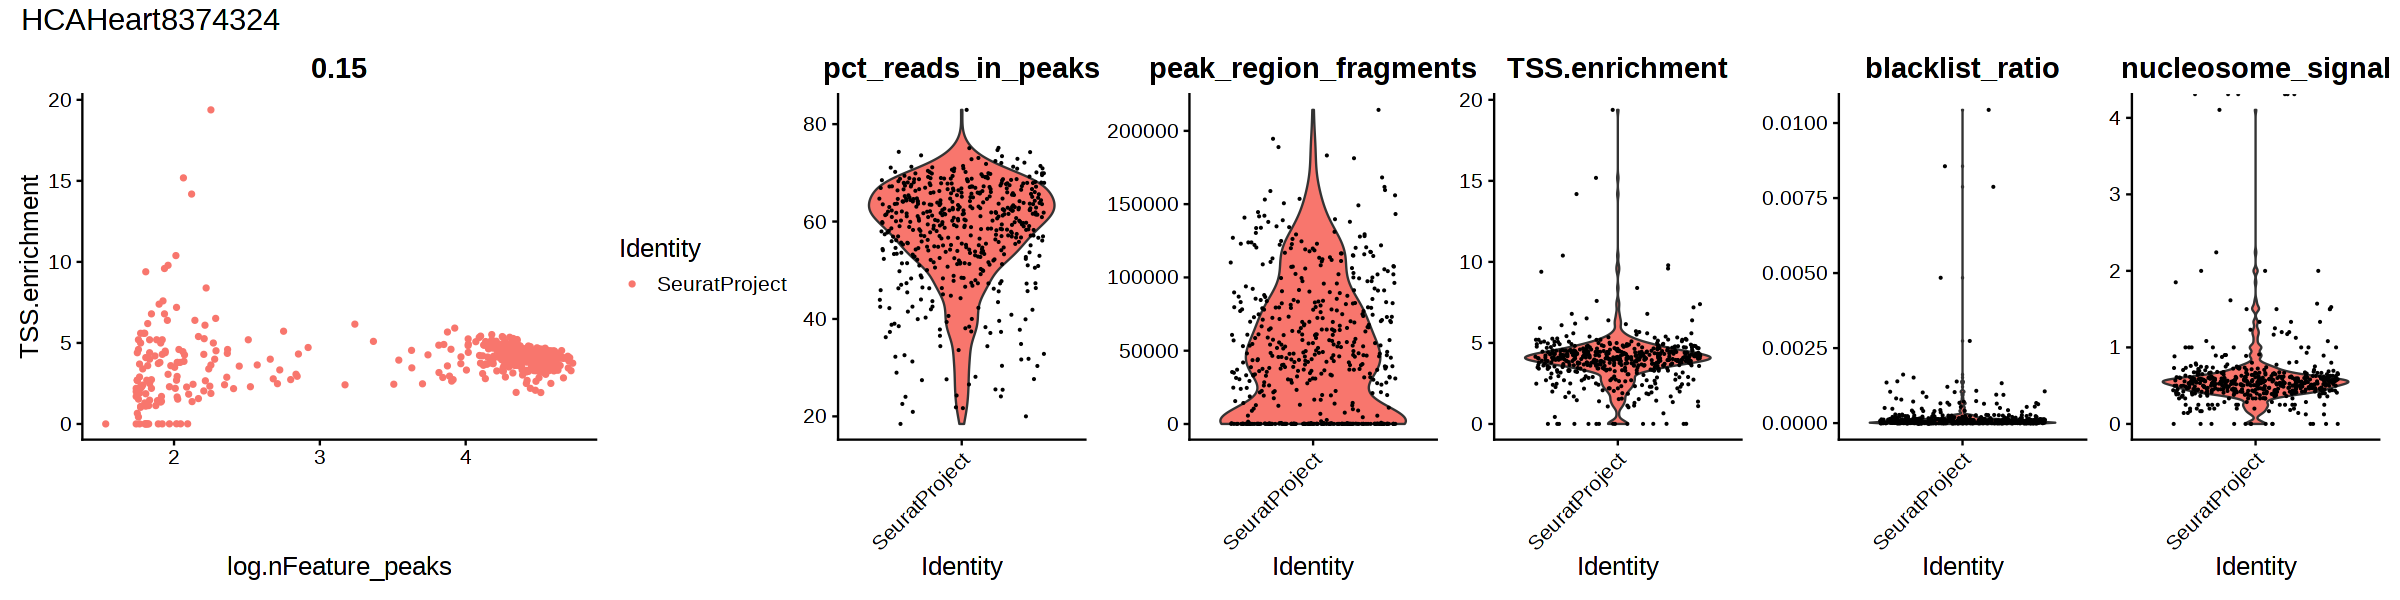

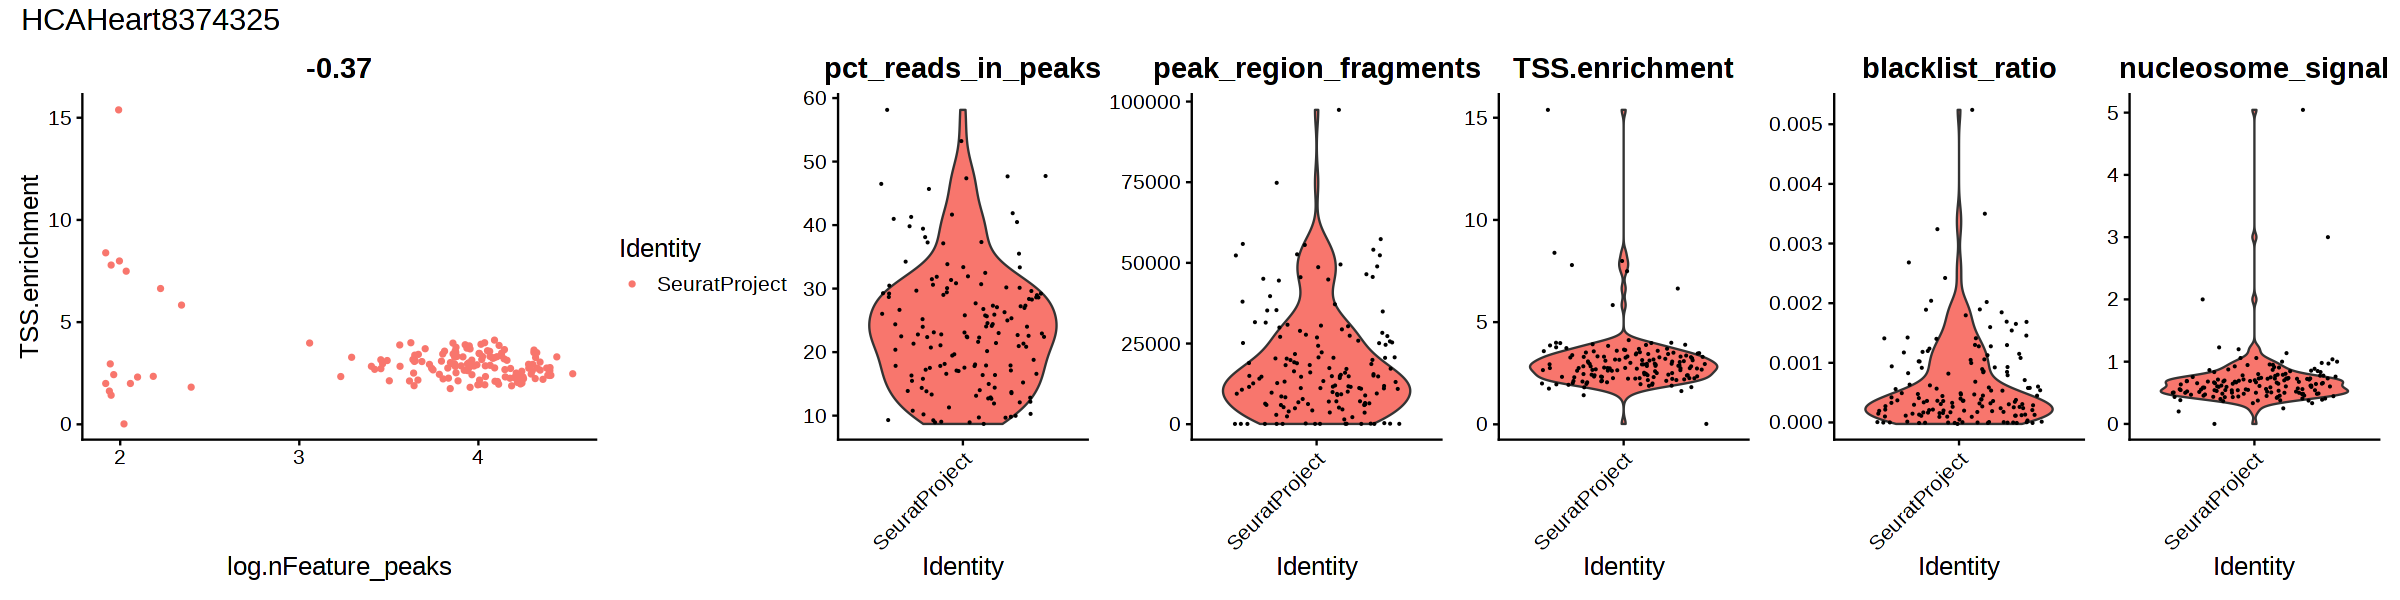

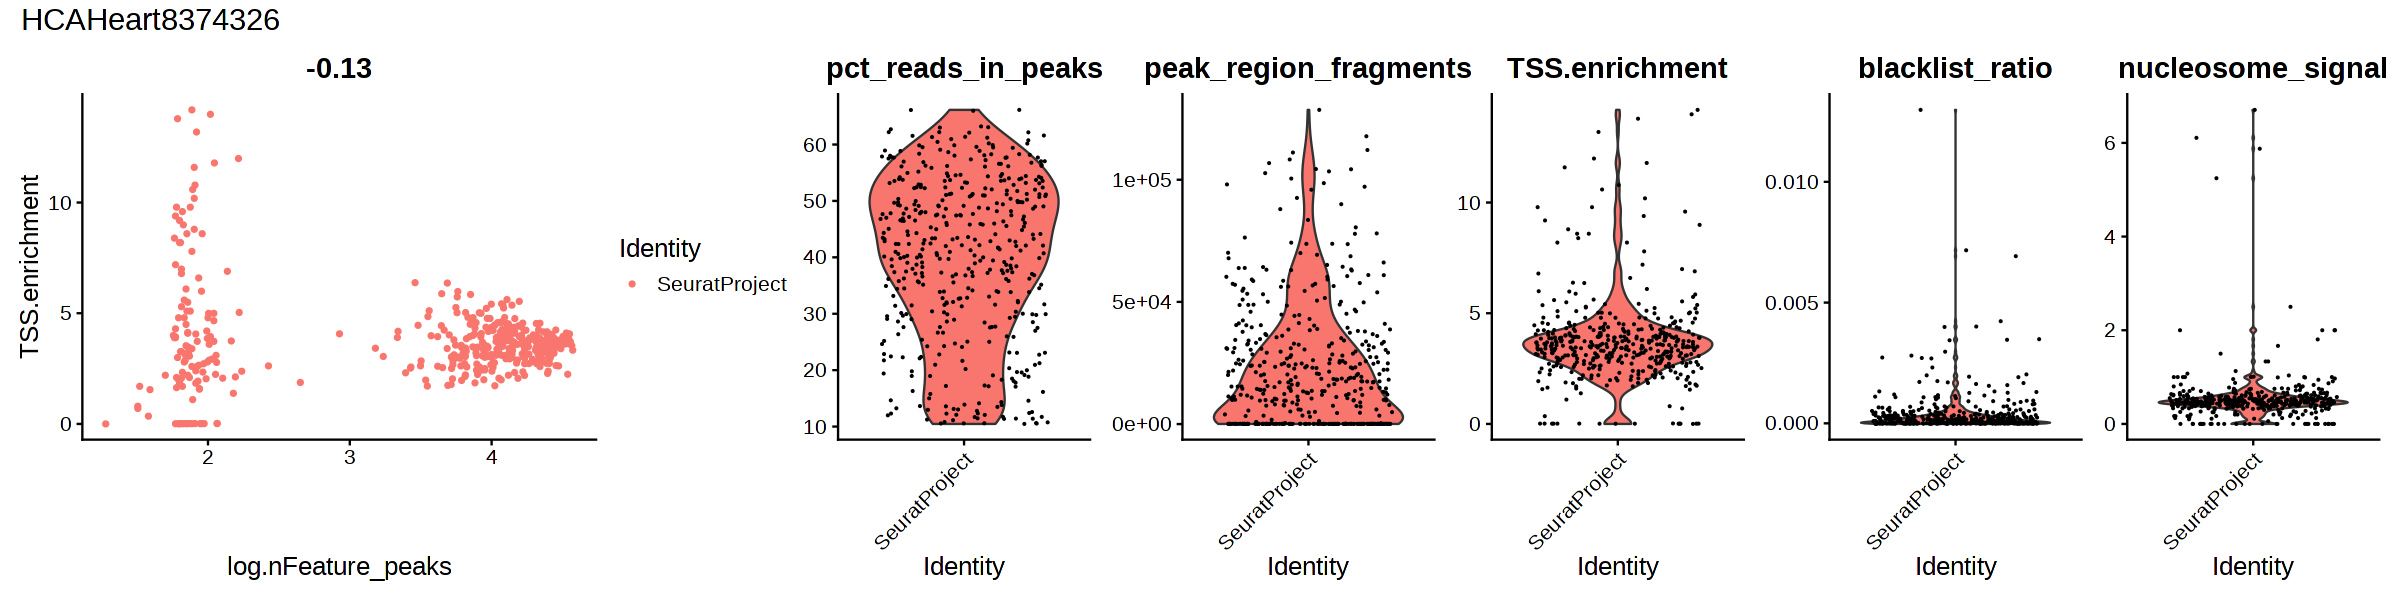

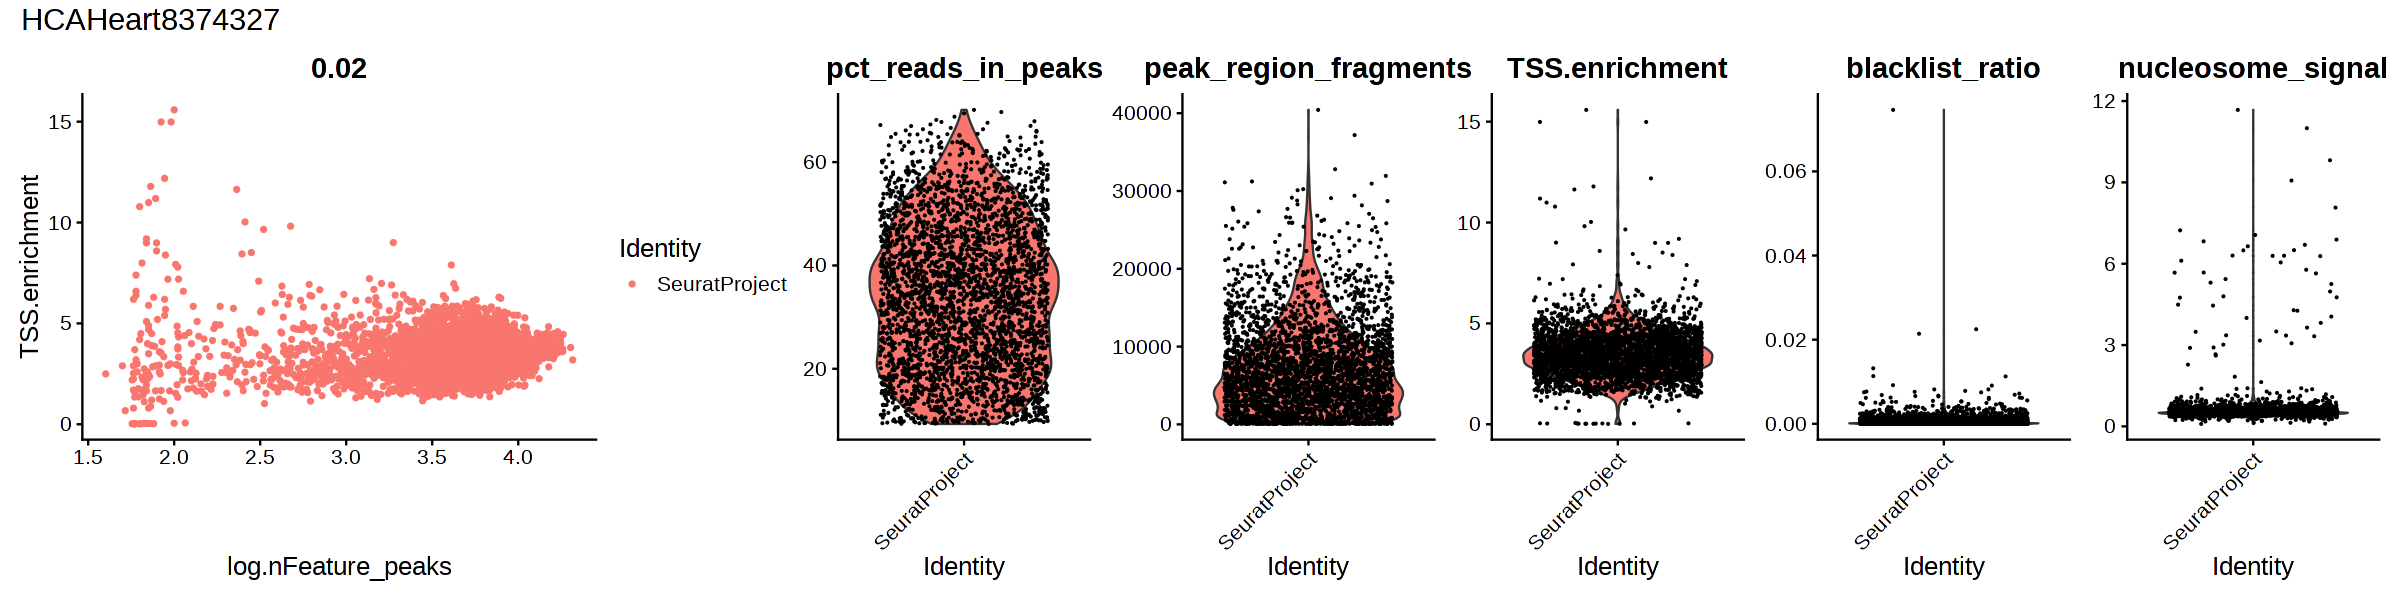

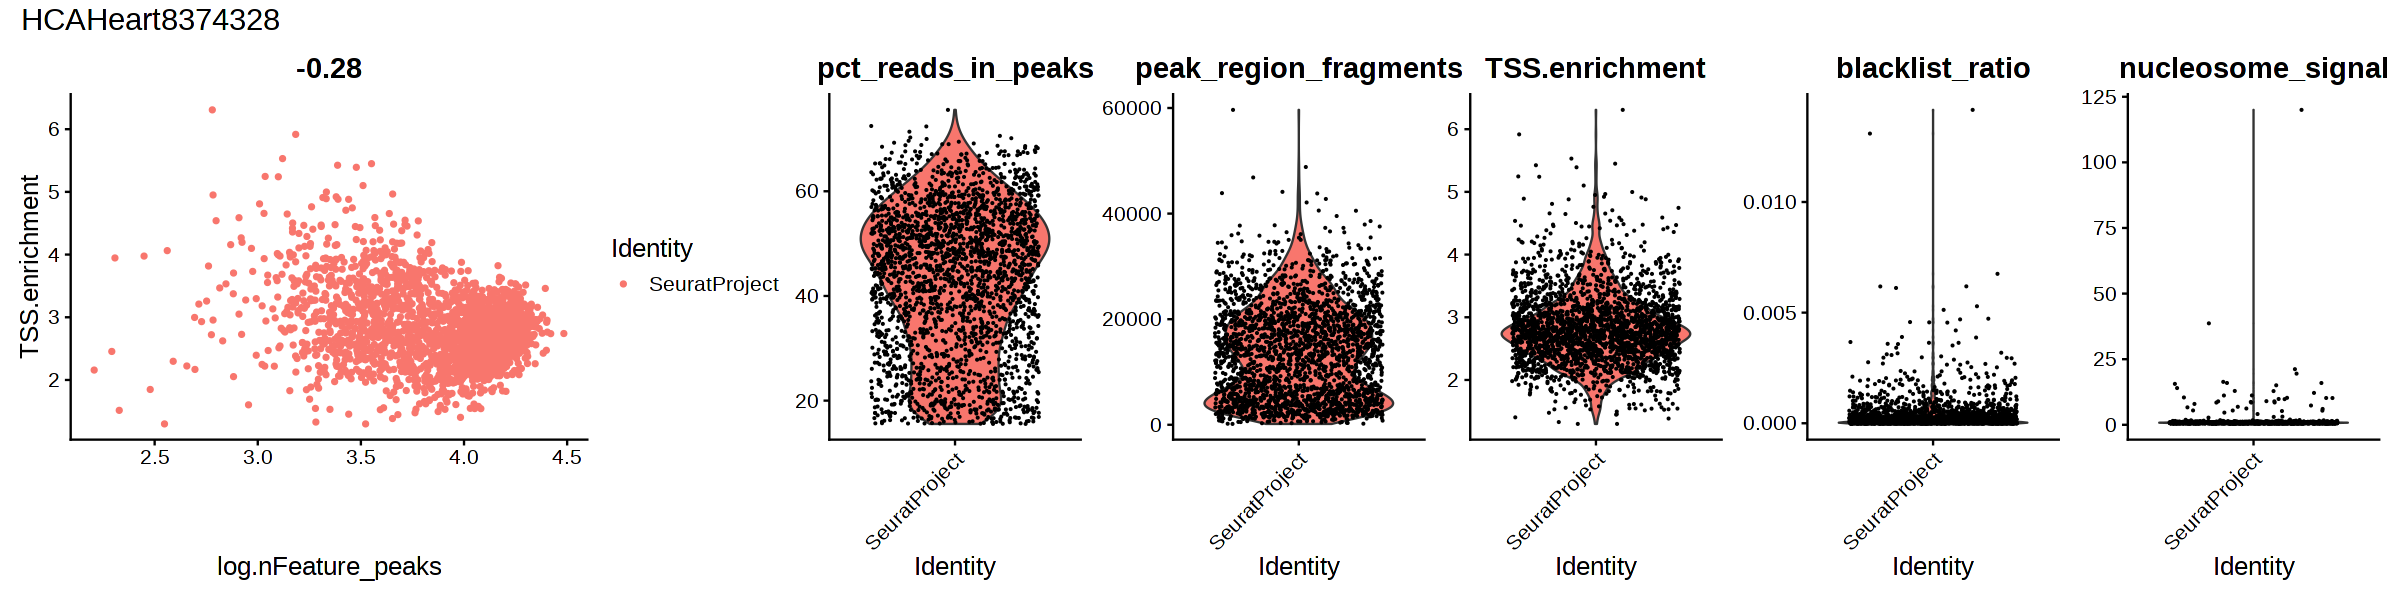

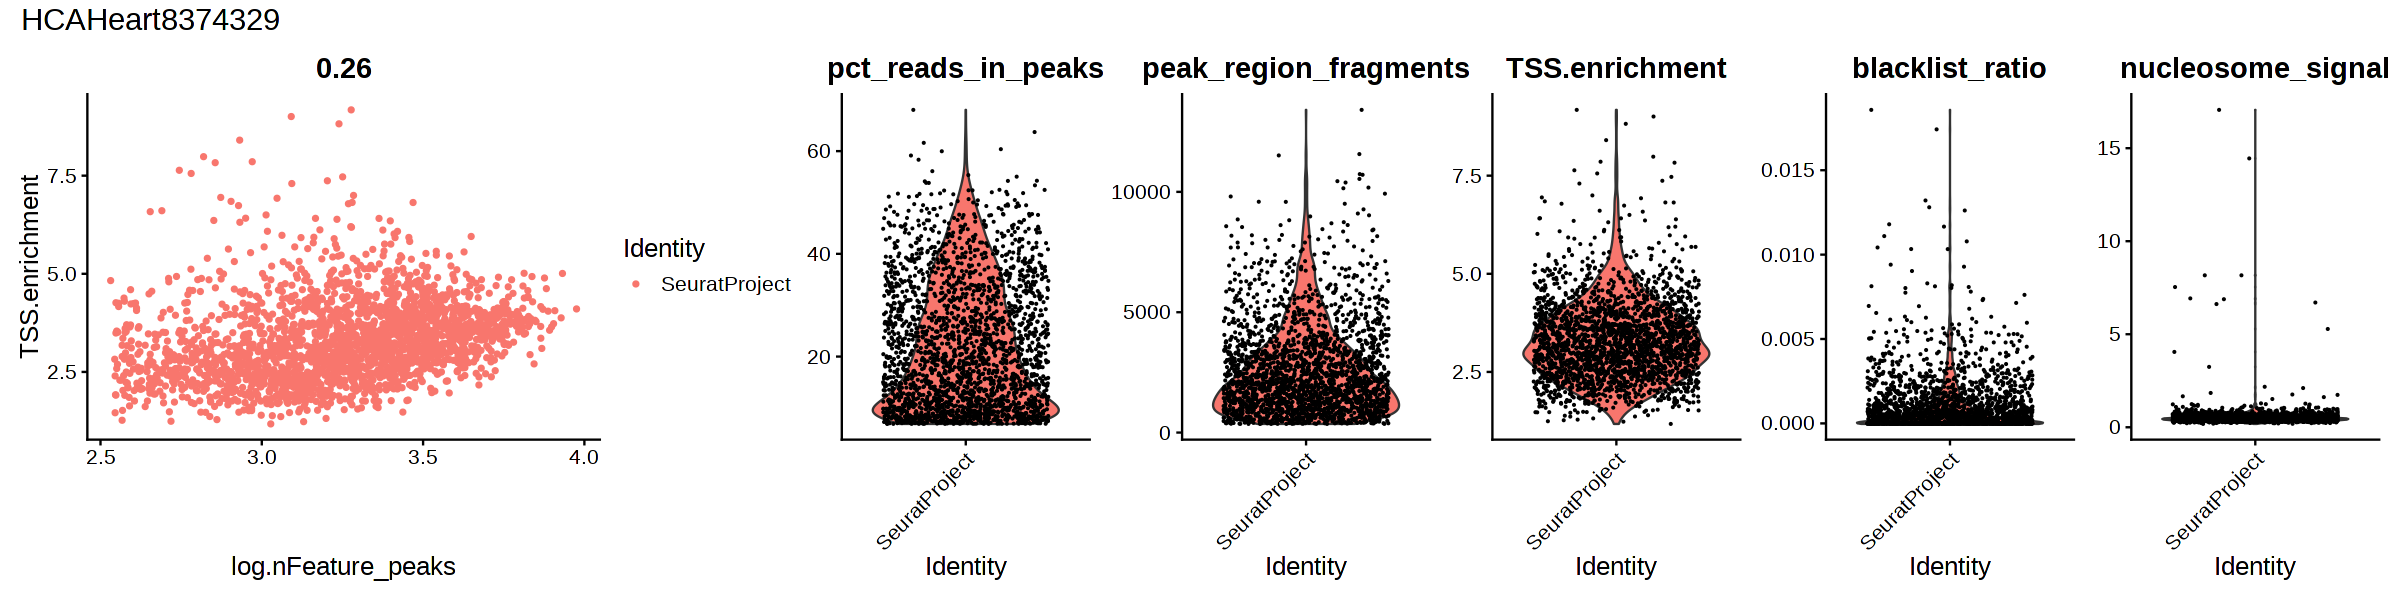

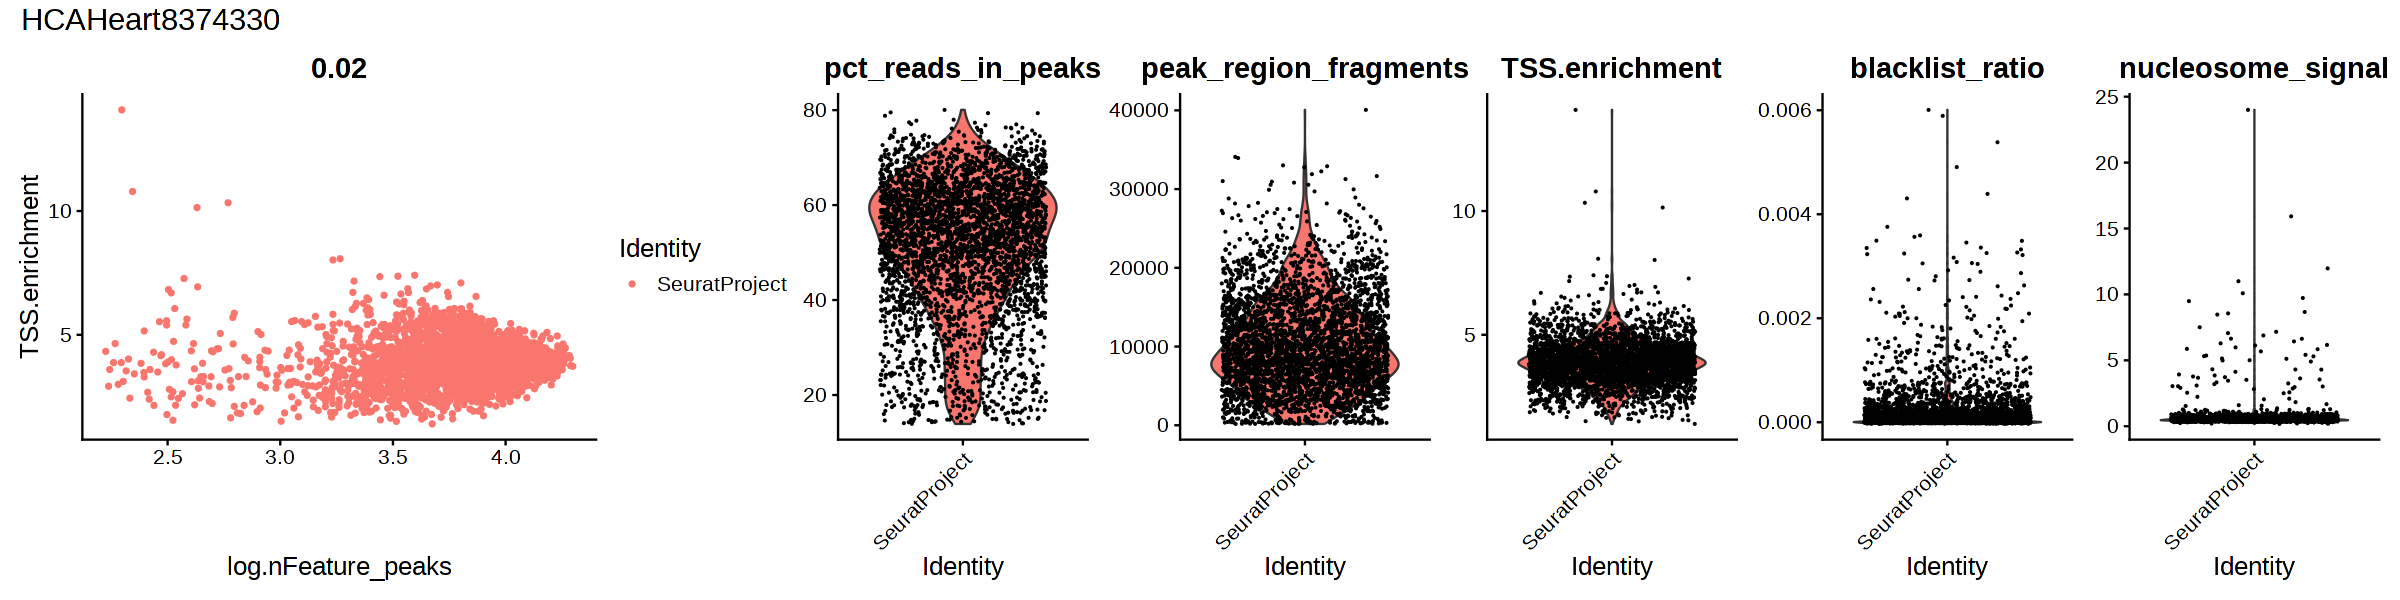

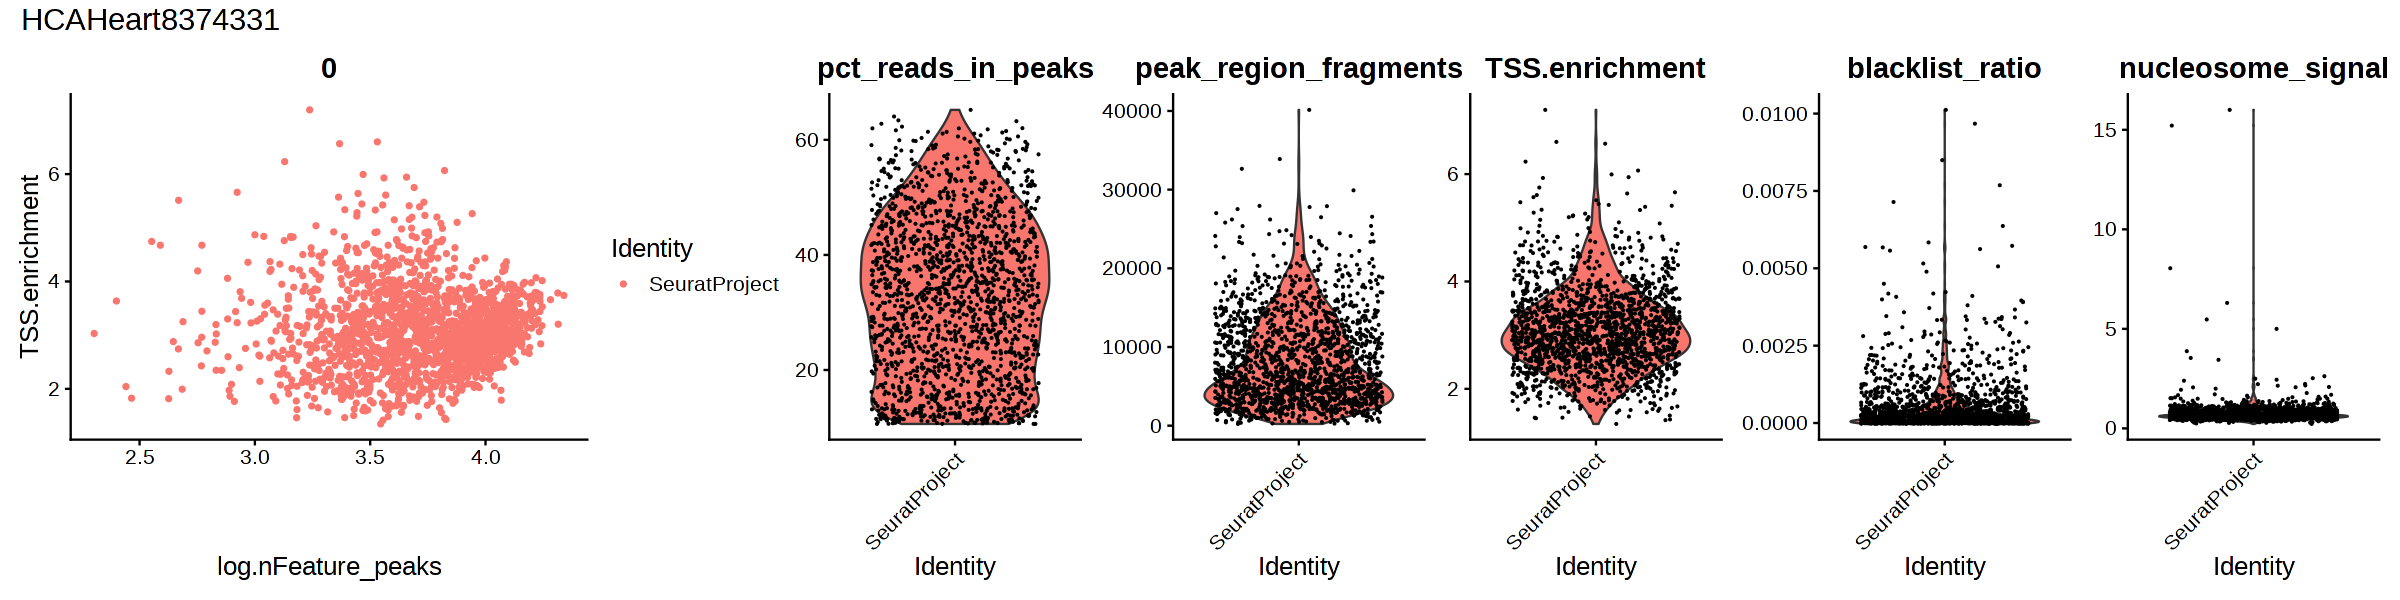

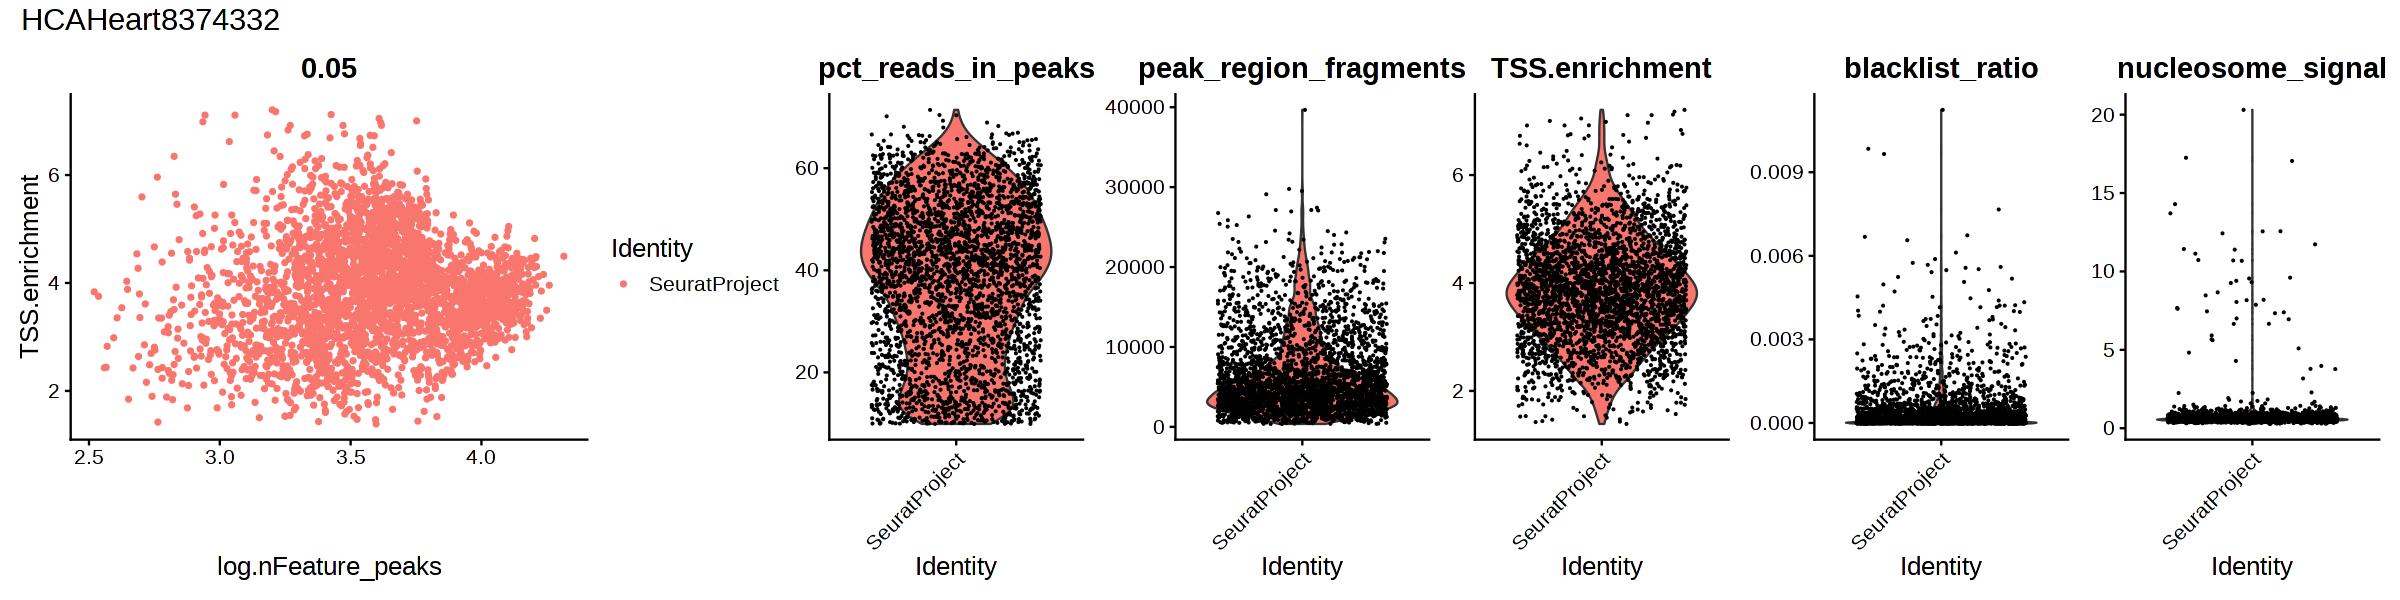

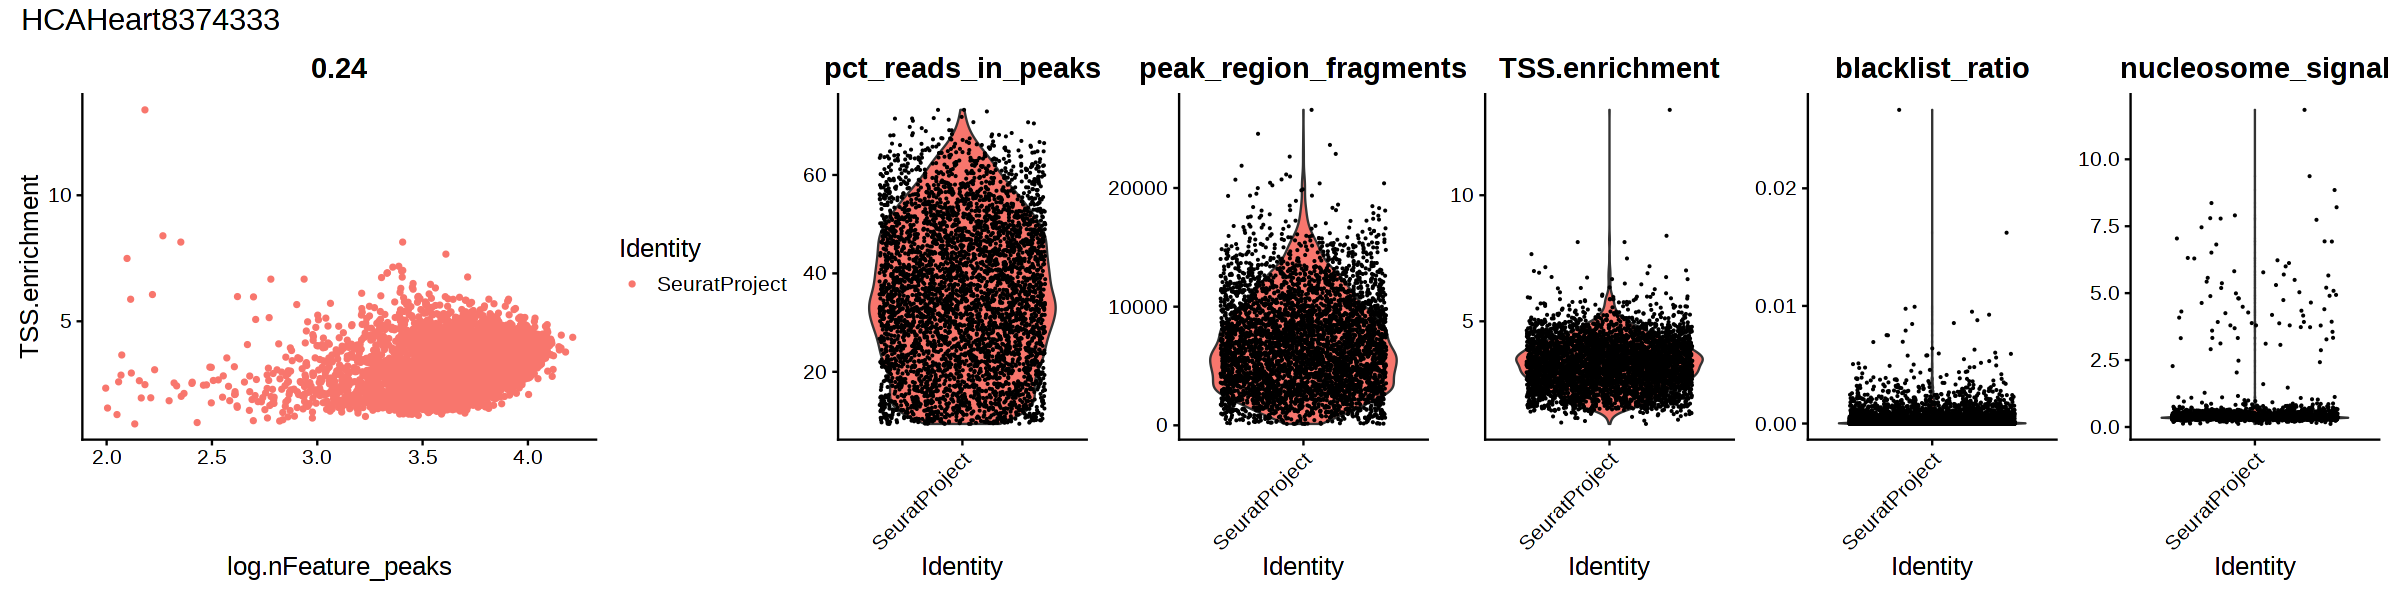

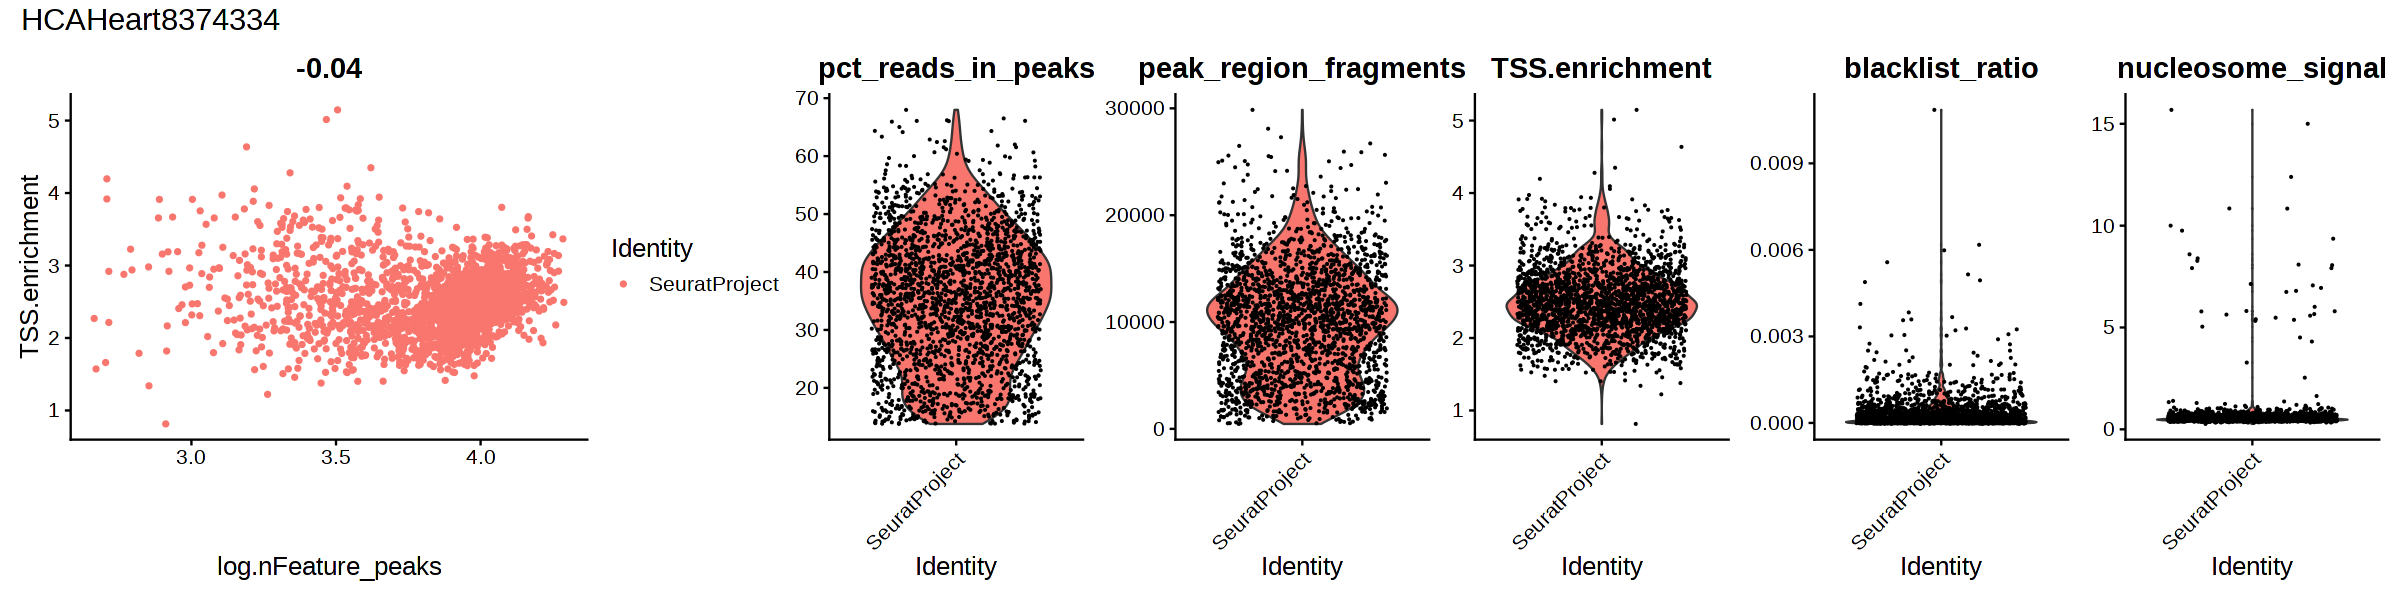

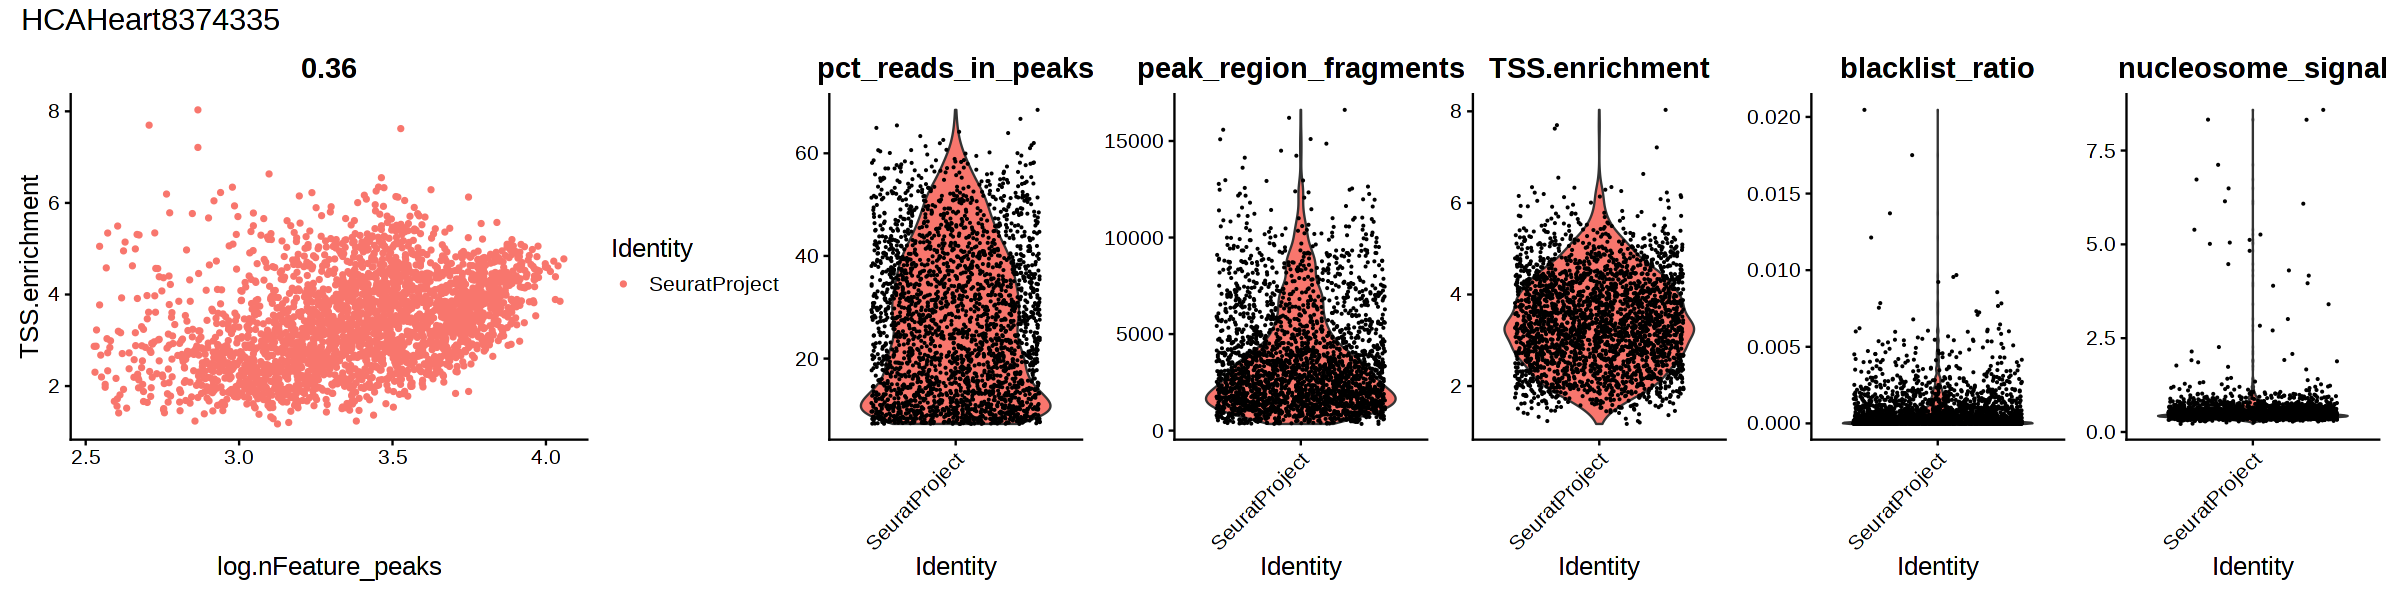

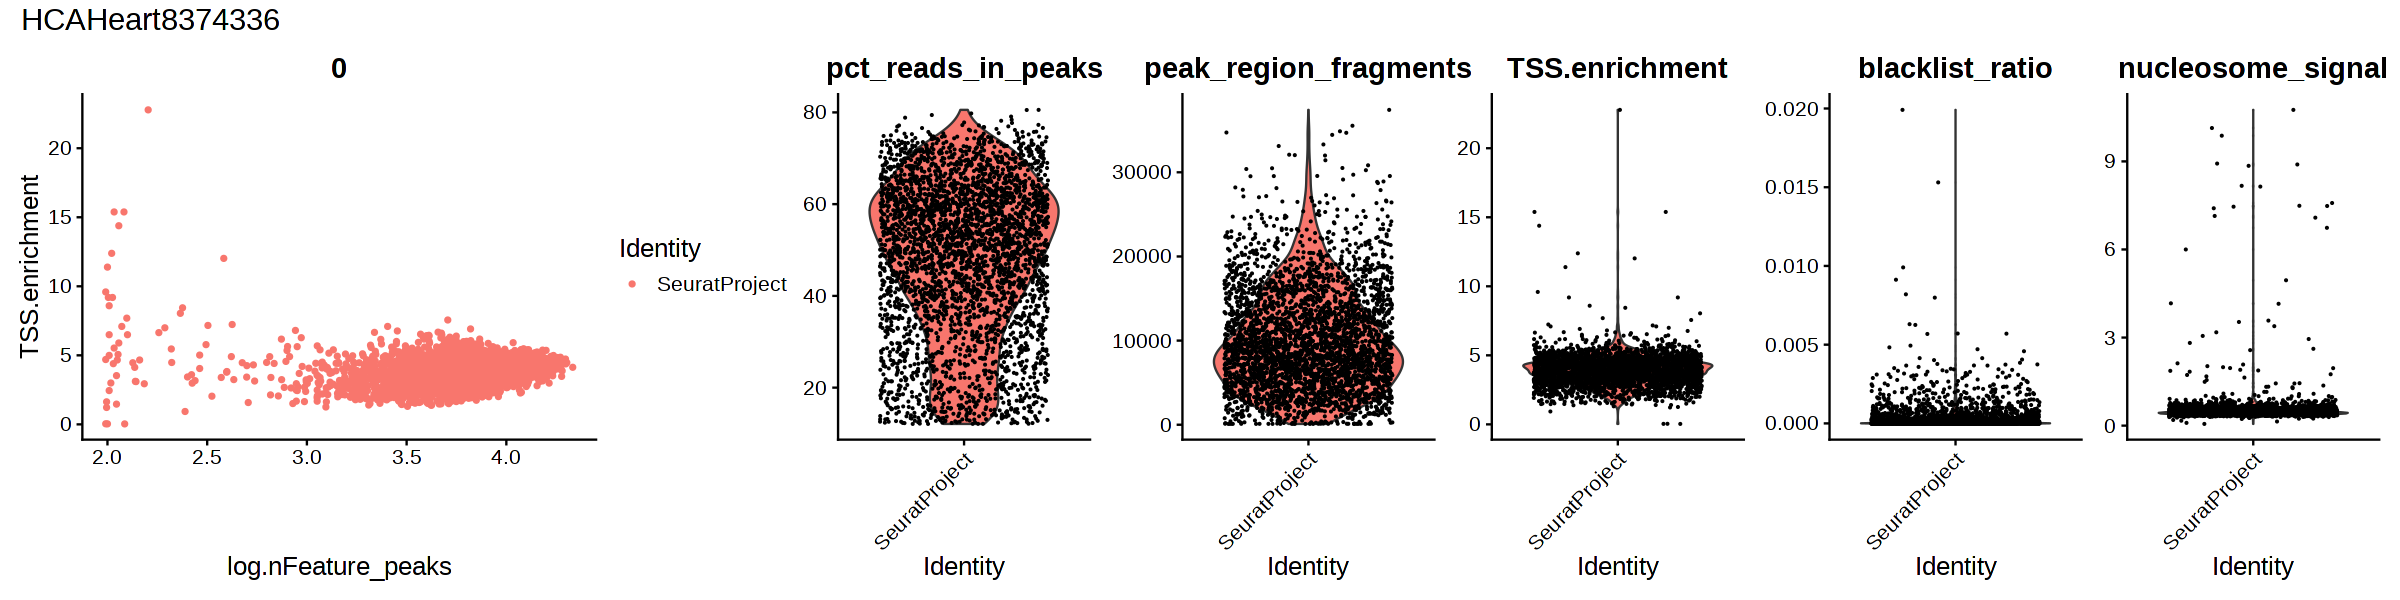

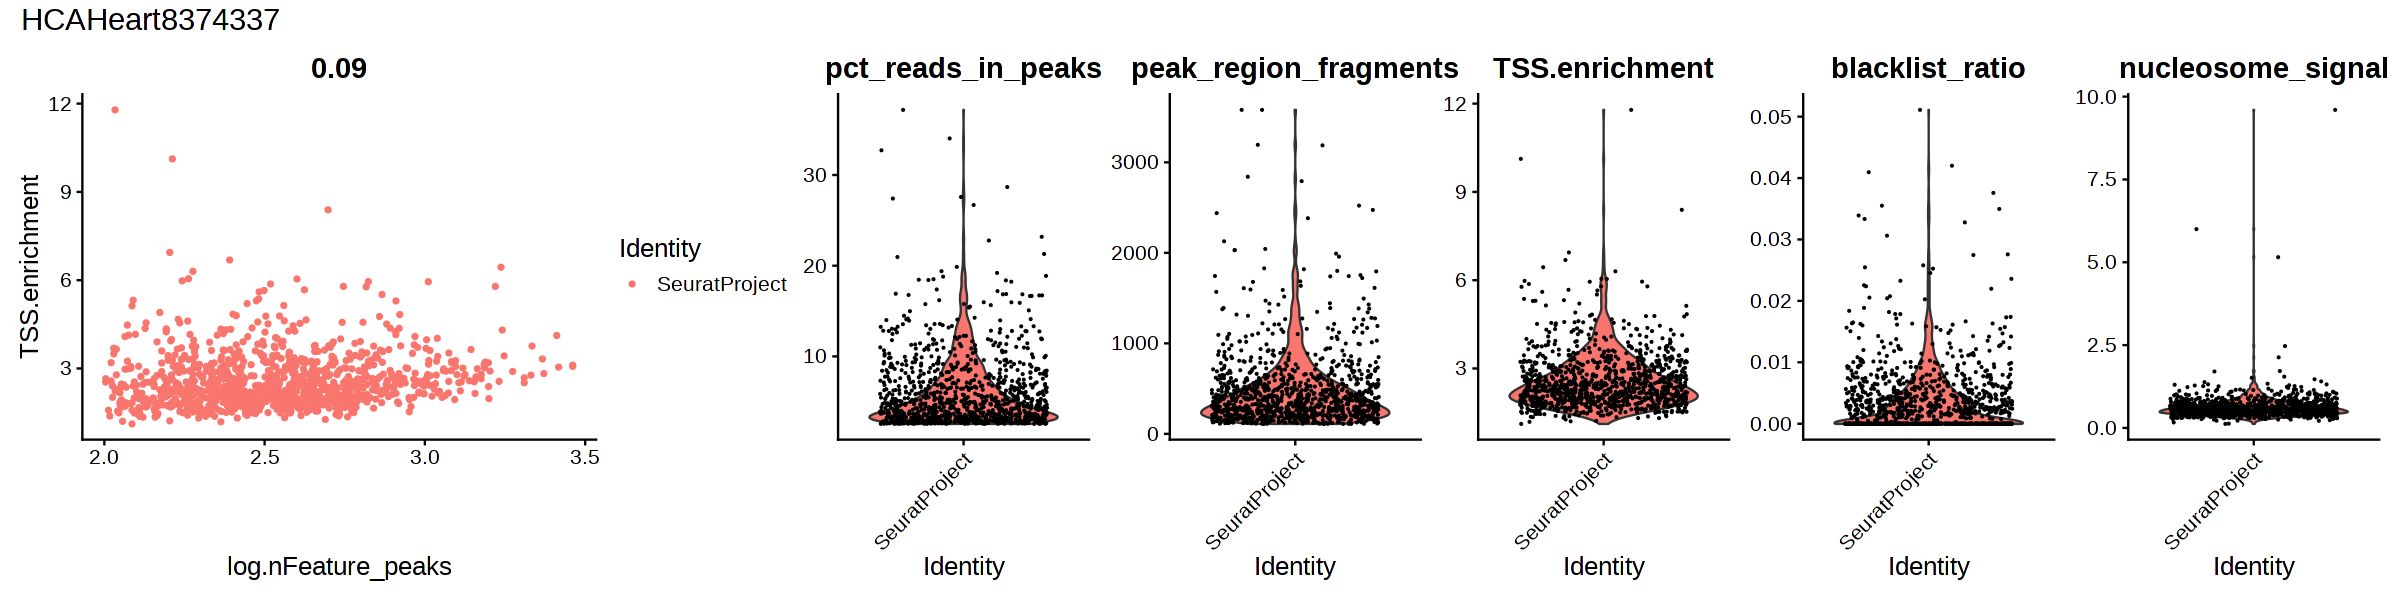

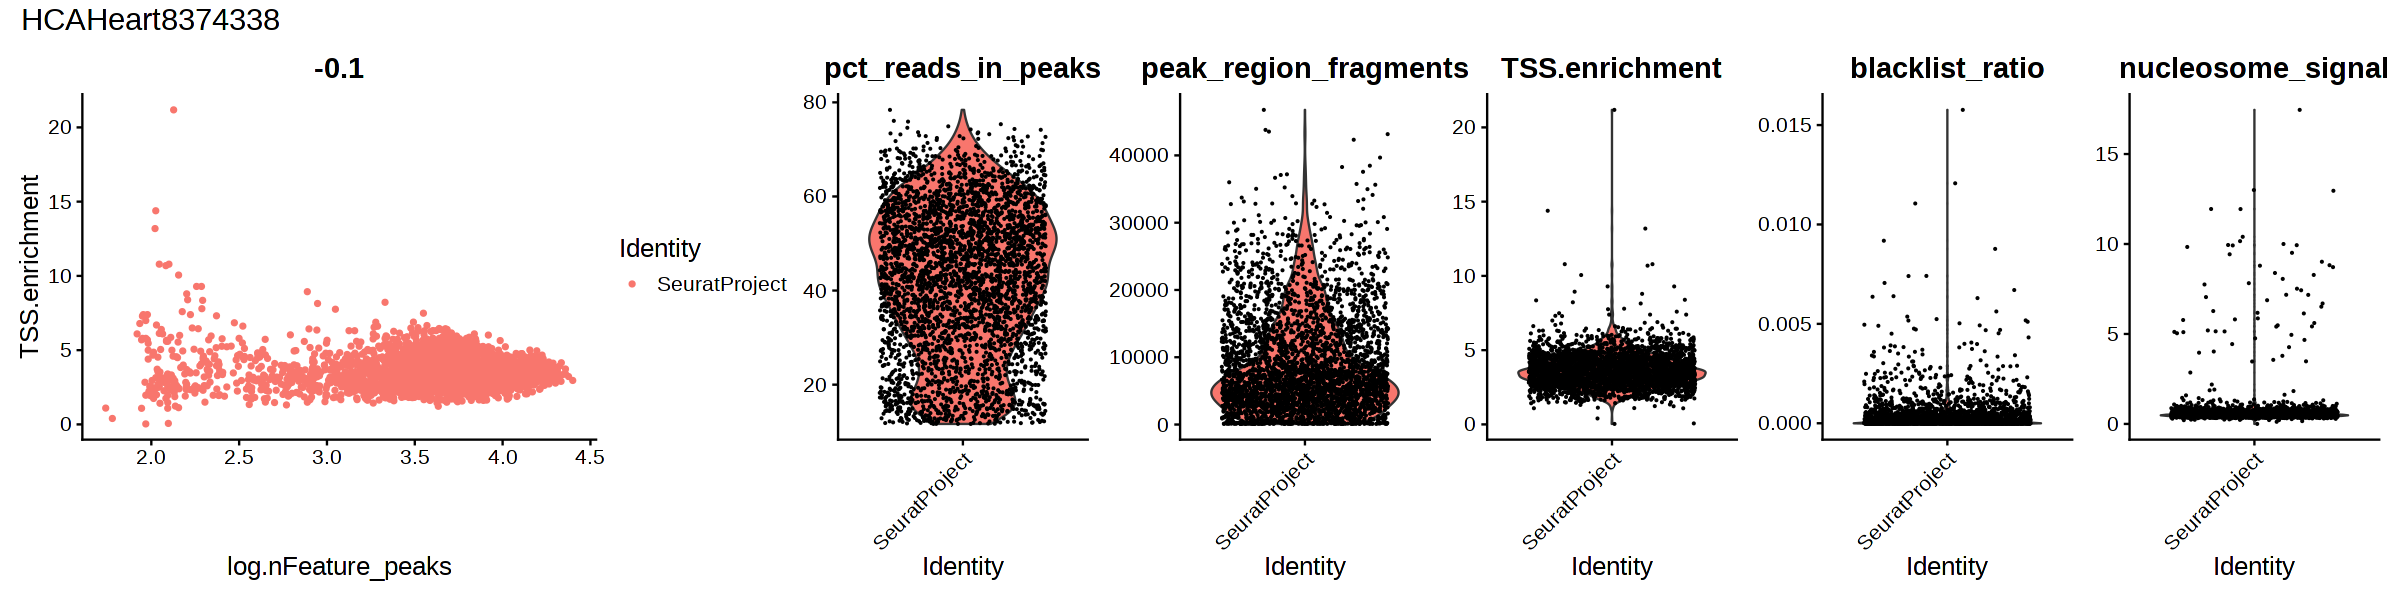

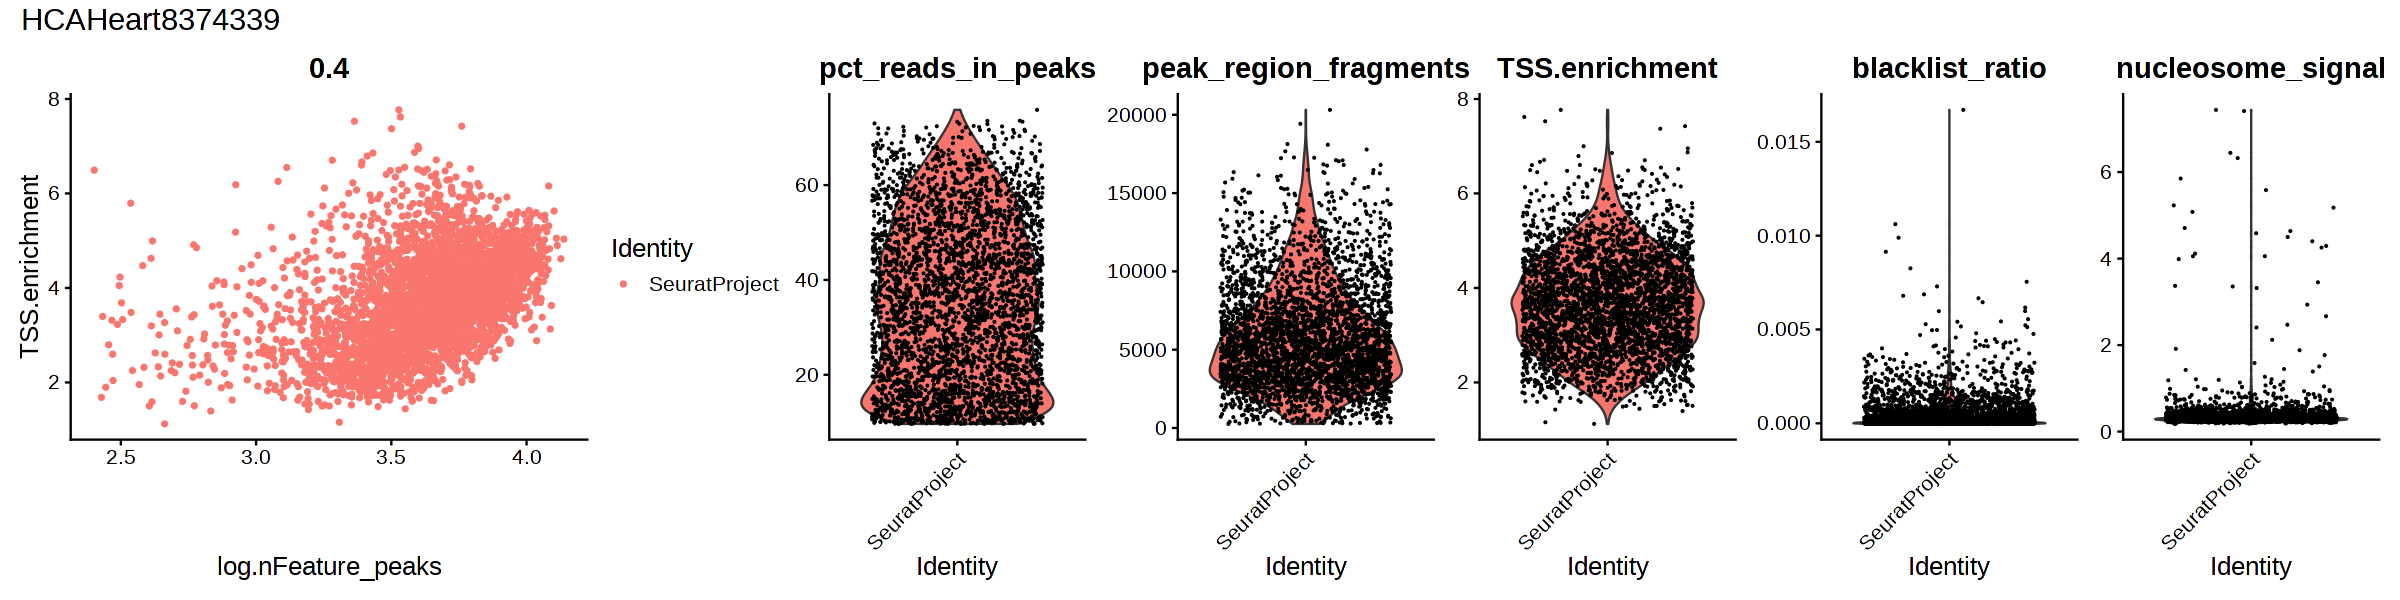

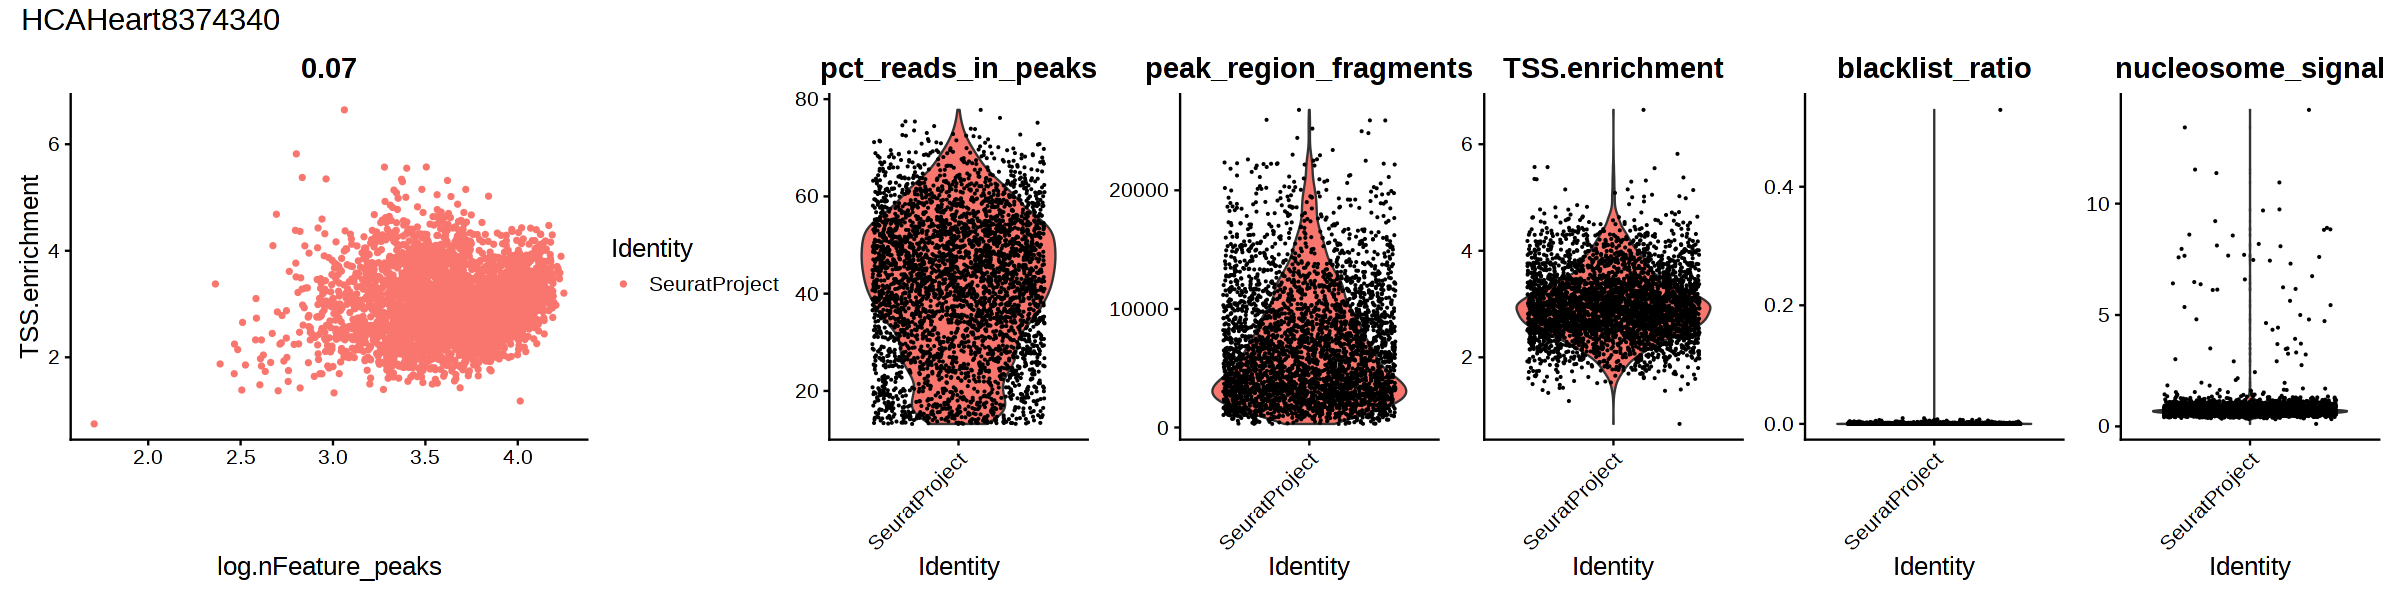

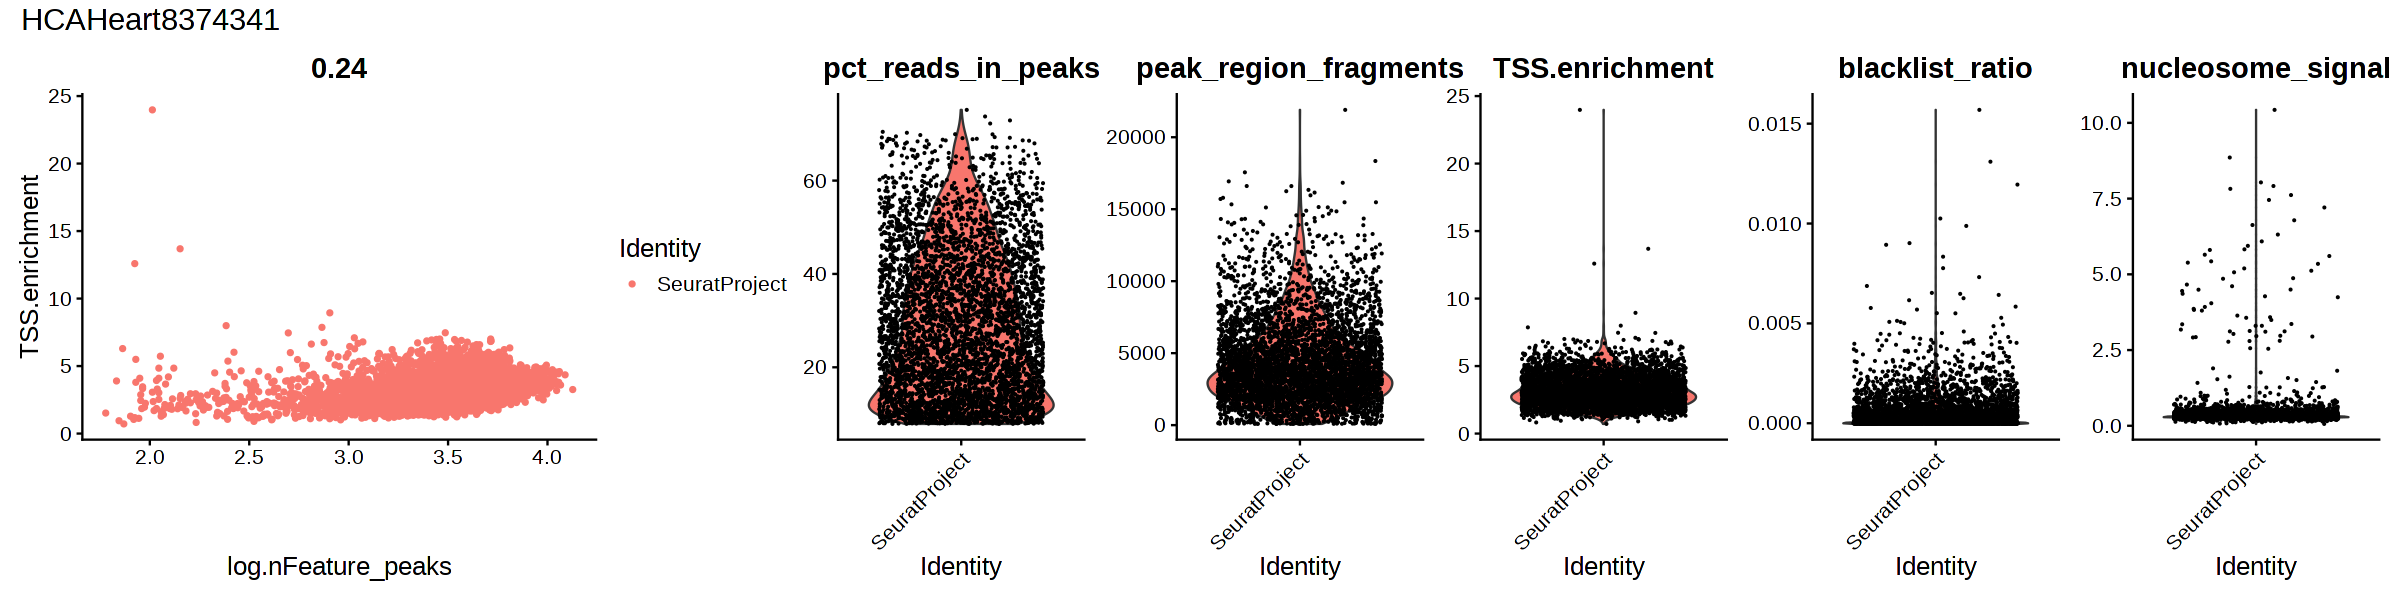

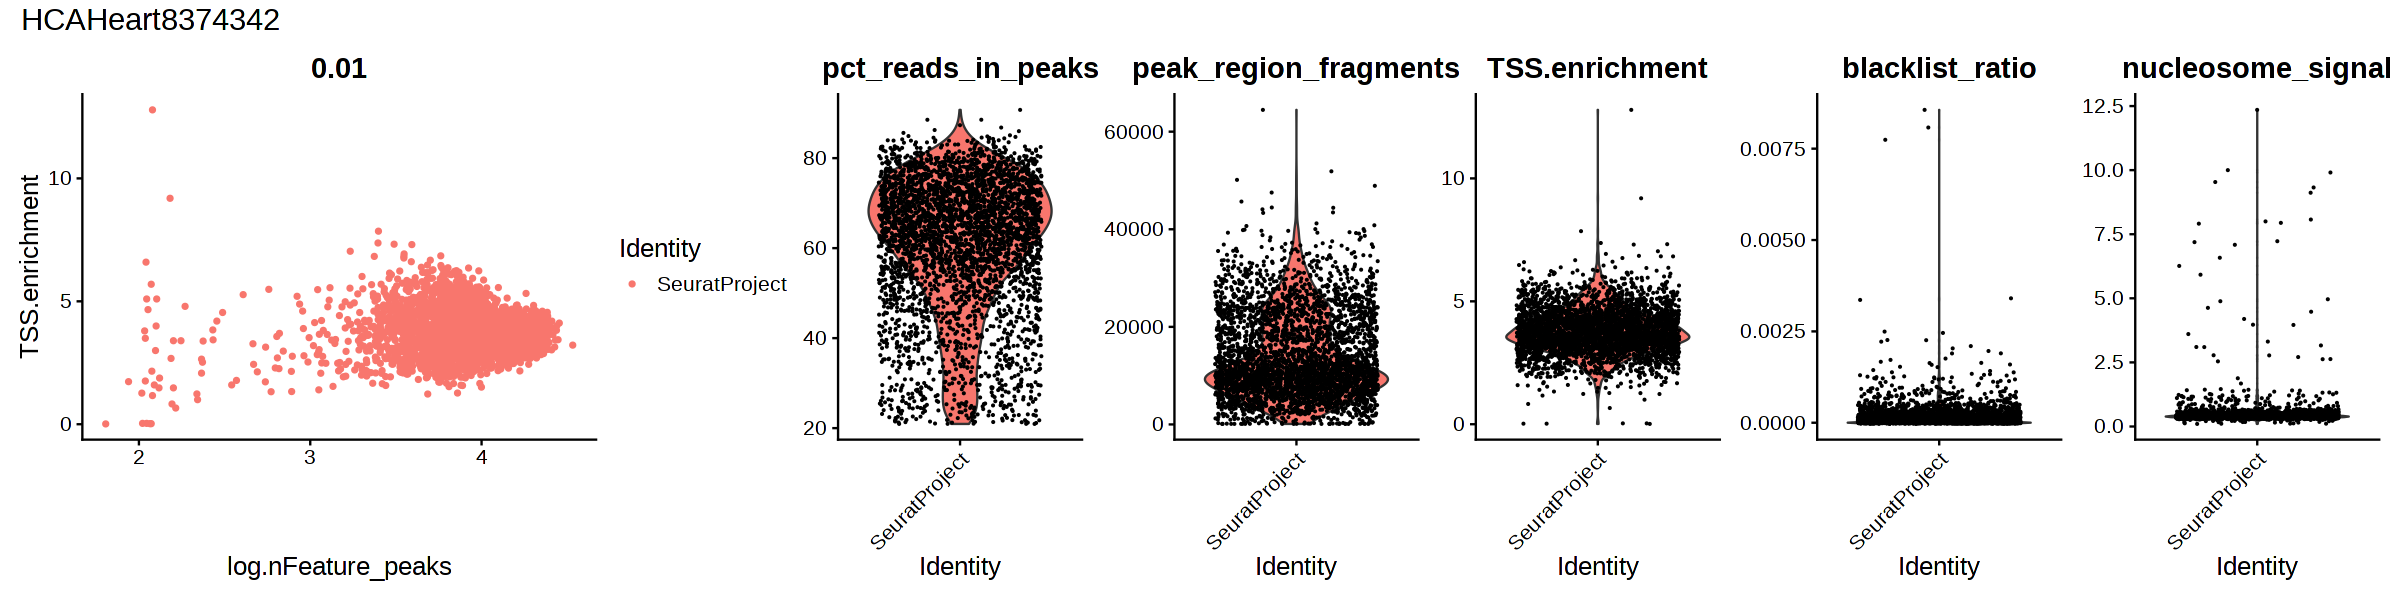

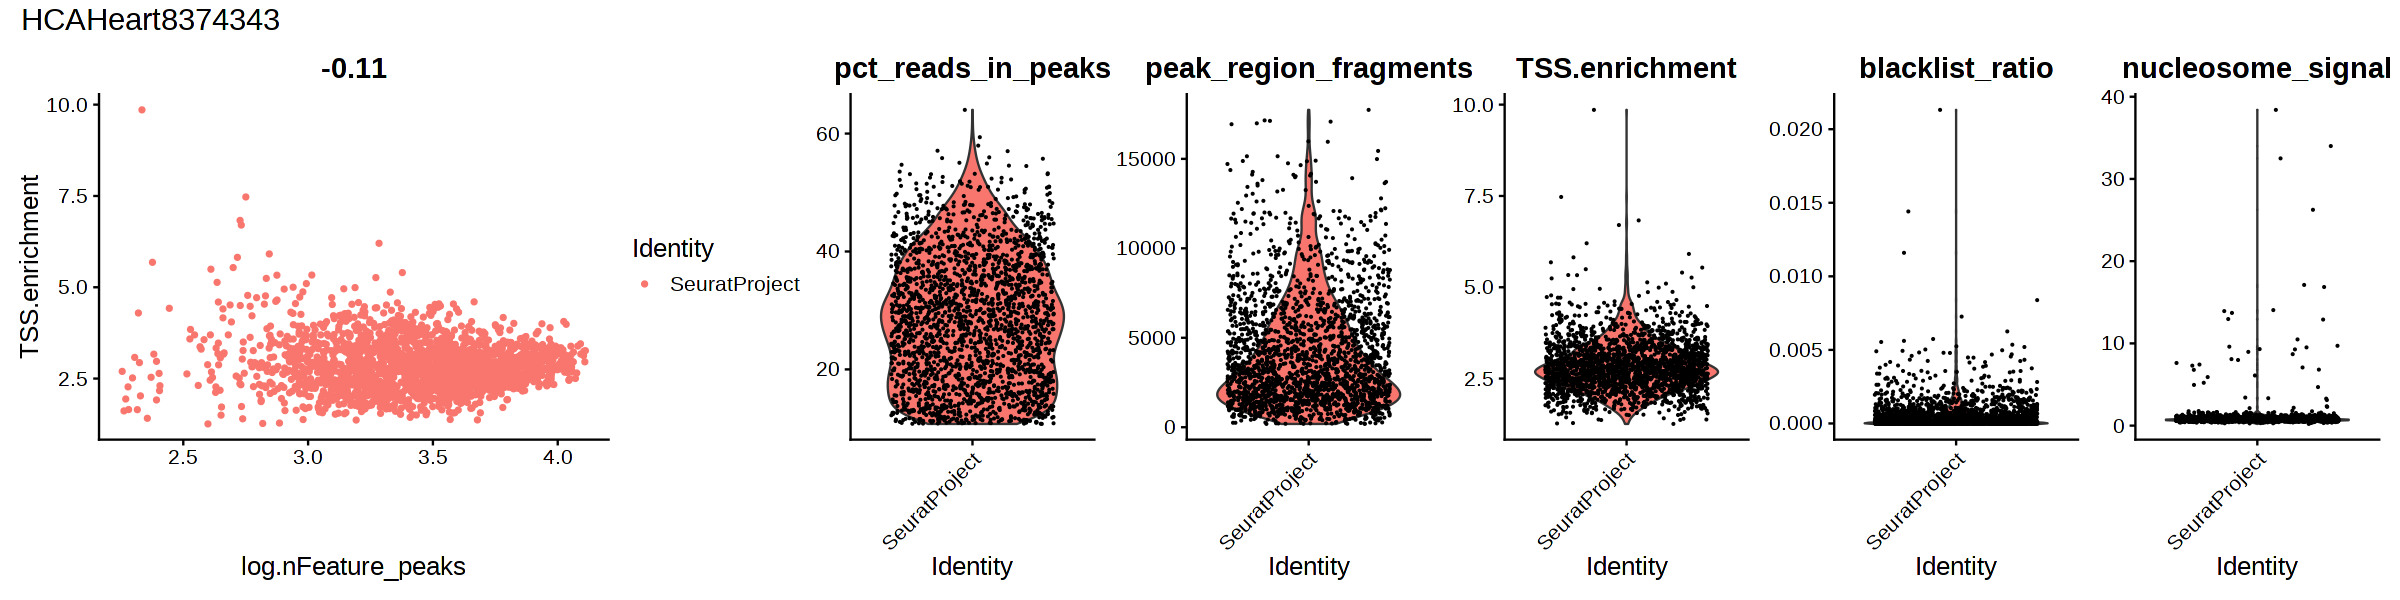

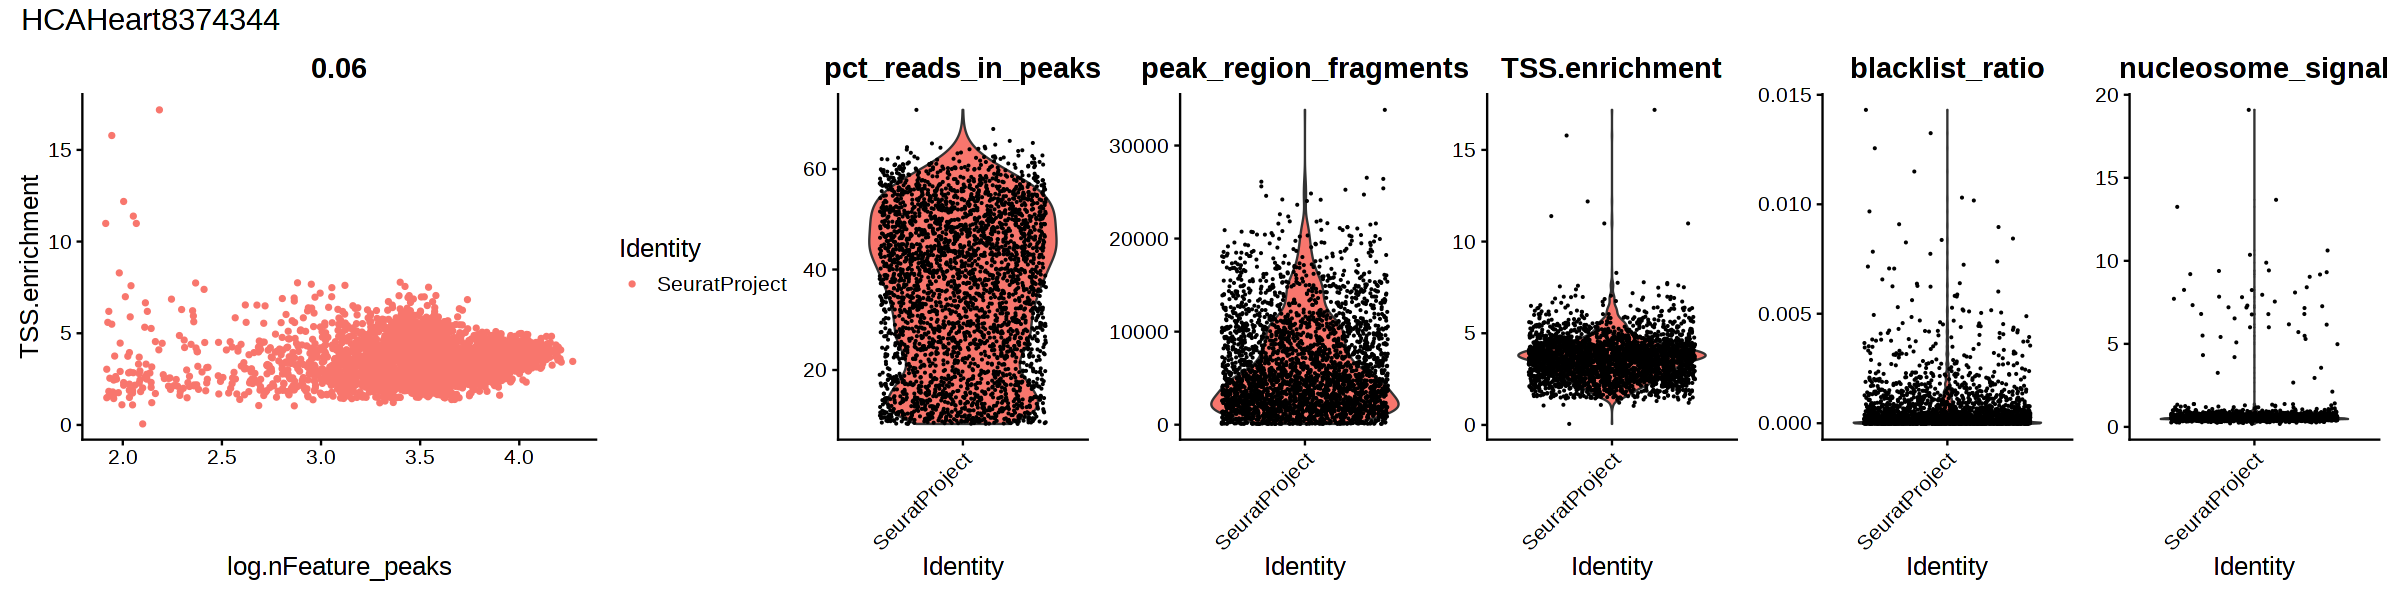

In [17]:
sangerIDs=metadata$SangerID

options(repr.plot.width = 20, repr.plot.height = 5)
for(ID in sangerIDs){
    so = readRDS(paste0(path2outs,ID,'/',ID,'_SeuratObj_QCed.RDS'))
    so@meta.data$log.nFeature_peaks=log10(so@meta.data$nFeature_peaks)
    
    p1 = FeatureScatter(object = so, feature1 = 'log.nFeature_peaks', feature2 = 'TSS.enrichment')
    p2 = VlnPlot(
        object = so,
        features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
        pt.size = 0.1,
        ncol = 5
    )
    P = p1+p2+plot_layout(nrow = 1, widths = c(1, 3))+plot_annotation(title = ID)&theme(title = element_text(size=15))
    plot(P)
}

## Filter out low quality cells and obtain good quality cell ID

In [18]:
SangerIDs=metadata$SangerID
SangerIDs=SangerIDs[SangerIDs!='HCAHeart8374337'] # since 'HCAHeart8374337' has only low quality cells

barcode=c()
for(ID in SangerIDs){
    print(ID)
    so = readRDS(paste0(path2outs,ID,'/',ID,'_SeuratObj_QCed.RDS'))
    
    print(dim(so))
    so = subset(
        x = so,
        subset = TSS.enrichment>2 &
            nucleosome_signal<2 &
            nFeature_peaks>1000
    )
    print(dim(so))

    barcode=c(barcode, paste(ID, colnames(so), sep='_'))
}

[1] "HCAHeart8374324"
[1] 128019    517
[1] 128019    373
[1] "HCAHeart8374325"
[1] 68367   151
[1] 68367   124
[1] "HCAHeart8374326"
[1] 78118   443
[1] 78118   301
[1] "HCAHeart8374327"
[1] 67998  3350
[1] 67998  2735
[1] "HCAHeart8374328"
[1] 110606   2410
[1] 110606   2259
[1] "HCAHeart8374329"
[1] 51885  2341
[1] 51885  1731
[1] "HCAHeart8374330"
[1] 102515   3776
[1] 102515   3580
[1] "HCAHeart8374331"
[1] 80296  1744
[1] 80296  1601
[1] "HCAHeart8374332"
[1] 73538  3181
[1] 73538  2972
[1] "HCAHeart8374333"
[1] 68560  4349
[1] 68560  3827
[1] "HCAHeart8374334"
[1] 105721   2100
[1] 105721   1799
[1] "HCAHeart8374335"
[1] 54280  2622
[1] 54280  2158
[1] "HCAHeart8374336"
[1] 88584  3443
[1] 88584  3247
[1] "HCAHeart8374338"
[1] 85279  3543
[1] 85279  3072
[1] "HCAHeart8374339"
[1] 71826  3479
[1] 71826  3252
[1] "HCAHeart8374340"
[1] 97018  3687
[1] 97018  3404
[1] "HCAHeart8374341"
[1] 58151  4659
[1] 58151  3742
[1] "HCAHeart8374342"
[1] 159764   3634
[1] 159764   3505
[1] "HCA

In [19]:
length(barcode)

[1] 48098

In [20]:
# save the barcodes of good quality cells
write.table(barcode, file = "/nfs/team205/kk18/data/mapped/cellranger-atac120/6reg-v2_snATAC_Signac-QCed-barcodes.txt", col.names = F, row.names = F)

In [21]:
barcode = read.table(file = "/nfs/team205/kk18/data/mapped/cellranger-atac120/6reg-v2_snATAC_Signac-QCed-barcodes.txt", header=F)
barcode

V1                                
1     HCAHeart8374324_AAACGAATCAAACCCA-1
2     HCAHeart8374324_AAAGGATAGGCACTAG-1
3     HCAHeart8374324_AAAGGGCAGCGAGCTA-1
4     HCAHeart8374324_AAAGGGCAGTGATATG-1
5     HCAHeart8374324_AAATGAGTCCGGGCAT-1
6     HCAHeart8374324_AAATGAGTCGATCGCG-1
7     HCAHeart8374324_AAATGCCCAAGCCCTG-1
8     HCAHeart8374324_AACAAAGCAAGTTGCT-1
9     HCAHeart8374324_AACAAAGGTTAAGTCC-1
10    HCAHeart8374324_AACAGTCCATACCCGG-1
11    HCAHeart8374324_AACATCGAGGTAGGCT-1
12    HCAHeart8374324_AACCGATCATGGCCCA-1
13    HCAHeart8374324_AACCTGACAGATTGTC-1
14    HCAHeart8374324_AACCTGATCAGTCTTT-1
15    HCAHeart8374324_AACCTGATCTTTATCG-1
16    HCAHeart8374324_AACGAGGCACGACGAA-1
17    HCAHeart8374324_AACGAGGGTTGCAGAG-1
18    HCAHeart8374324_AACGGGAAGACACTTC-1
19    HCAHeart8374324_AACGGGATCGATAGCT-1
20    HCAHeart8374324_AACTGGTCACAATAAG-1
21    HCAHeart8374324_AACTGGTCACCGTCTT-1
22    HCAHeart8374324_AACTTGGGTCGTCGCA-1
23    HCAHeart8374324_AAGGAGCAGGGTTCCC-1
24    HCAHeart8374324_AATACGCGTTCTACGA-1
25    HCAHeart8374324_AATGGAAAGGACTAGC-1
26    HCAHeart8374324_AATGGAATCAAATGGA-1
27    HCAHeart8374324_AATGGCTAGAAACGCC-1
28    HCAHeart8374324_ACAATCGGTGTGCGTC-1
29    HCAHeart8374324_ACAATCGTCGATGCAT-1
30    HCAHeart8374324_ACATGGTAGTCTTAGC-1
⋮     ⋮                                 
48069 HCAHeart8374344_TTGTTGTCAGGTCCTG-1
48070 HCAHeart8374344_TTGTTGTCATTACCTT-1
48071 HCAHeart8374344_TTGTTGTGTAAACCCT-1
48072 HCAHeart8374344_TTGTTGTGTAACGGCA-1
48073 HCAHeart8374344_TTGTTGTGTGCAGACA-1
48074 HCAHeart8374344_TTGTTGTTCCAGAATC-1
48075 HCAHeart8374344_TTGTTGTTCCTTGACC-1
48076 HCAHeart8374344_TTGTTGTTCGGACGAA-1
48077 HCAHeart8374344_TTTACGTAGCCATGGA-1
48078 HCAHeart8374344_TTTACGTGTAACGTAA-1
48079 HCAHeart8374344_TTTACGTGTCACTCTC-1
48080 HCAHeart8374344_TTTACGTGTGACGCAA-1
48081 HCAHeart8374344_TTTACGTGTGGACGAT-1
48082 HCAHeart8374344_TTTGAGGAGTCCAGAG-1
48083 HCAHeart8374344_TTTGAGGTCACTAGGT-1
48084 HCAHeart8374344_TTTGAGGTCTTCATAC-1
48085 HCAHeart8374344_TTTGCGCAGCACGTAG-1
48086 HCAHeart8374344_TTTGCGCAGCCGCTGT-1
48087 HCAHeart8374344_TTTGGCCAGCAATGTA-1
48088 HCAHeart8374344_TTTGGCCGTATTCTGG-1
48089 HCAHeart8374344_TTTGGCCTCGATGTGT-1
48090 HCAHeart8374344_TTTGGCCTCTCCTTAA-1
48091 HCAHeart8374344_TTTGGTTAGGGAAGCG-1
48092 HCAHeart8374344_TTTGGTTCAATTGCCA-1
48093 HCAHeart8374344_TTTGGTTCACGCTGTG-1
48094 HCAHeart8374344_TTTGGTTTCATTGCCC-1
48095 HCAHeart8374344_TTTGGTTTCGTTACAG-1
48096 HCAHeart8374344_TTTGTGTAGTACAACA-1
48097 HCAHeart8374344_TTTGTGTCACTGTCGG-1
48098 HCAHeart8374344_TTTGTGTGTGCCAAGA-1